# Homework: Galaxy Image Classification

**Course:** Deep Learning for Computer Vision

**Objective:** Train a deep learning model to classify galaxy images from the Galaxy10 DECals dataset into one of 10 categories.

**Dataset:** Galaxy10 DECals
* **Source:** [Hugging Face Datasets](https://huggingface.co/datasets/matthieulel/galaxy10_decals)
* **Description:** Contains 17,736 color galaxy images (256x256 pixels) divided into 10 classes. Images originate from DESI Legacy Imaging Surveys, with labels from Galaxy Zoo.
* **Classes:**
    * 0: Disturbed Galaxies
    * 1: Merging Galaxies
    * 2: Round Smooth Galaxies
    * 3: In-between Round Smooth Galaxies
    * 4: Cigar Shaped Smooth Galaxies
    * 5: Barred Spiral Galaxies
    * 6: Unbarred Tight Spiral Galaxies
    * 7: Unbarred Loose Spiral Galaxies
    * 8: Edge-on Galaxies without Bulge
    * 9: Edge-on Galaxies with Bulge

**Tasks:**
1.  Load and explore the dataset.
2.  Preprocess the images.
3.  Define and train a model.
4.  Evaluate the model's performance using standard classification metrics on the test set.

Homework is succesfully completed if you get >0.9 Accuracy on the Test set.

# Prerequisites

In [1]:
!pip install datasets scikit-learn matplotlib numpy -q >> None

import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cufft-cu12 11.3.3.83 which is incompatible.
torch 2.5.1+cu124 requires nvidia-curand-cu12==10.3.5.147; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-curand-cu12 10.3.9.90 which is incompatible.


In [2]:
# Cell 4: Visualize one example from each class
def show_class_examples(dataset, class_names_map, samples_per_row=5, num_rows=2):
    """Displays one sample image for each class."""
    if not dataset:
        print("Dataset not loaded. Cannot visualize.")
        return

    num_classes_to_show = len(class_names_map)
    if num_classes_to_show > samples_per_row * num_rows:
        print(f"Warning: Not enough space to show all {num_classes_to_show} classes.")
        num_classes_to_show = samples_per_row * num_rows

    fig, axes = plt.subplots(num_rows, samples_per_row, figsize=(15, 6)) # Adjusted figsize
    axes = axes.ravel() # Flatten the axes array

    split_name = 'train' if 'train' in dataset else list(dataset.keys())[0]
    data_split = dataset[split_name]

    images_shown = 0
    processed_labels = set()

    for i in range(len(data_split)):
        if images_shown >= num_classes_to_show:
            break # Stop once we have shown one for each target class

        example = data_split[i]
        label = example['label']

        if label not in processed_labels and label < num_classes_to_show:
            img = example['image']
            ax_idx = label # Use label directly as index into the flattened axes
            axes[ax_idx].imshow(img)
            axes[ax_idx].set_title(f"Class {label}: {class_names_map[label]}", fontsize=9)
            axes[ax_idx].axis('off')
            processed_labels.add(label)
            images_shown += 1

    # Hide any unused subplots
    for i in range(images_shown, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [3]:
def evaluate_predictions(predicted_labels, true_labels, class_names_list):
    """
    Calculates and prints classification metrics from predicted labels and true labels.

    Args:
        predicted_labels (list or np.array): The predicted class indices for the test set.
        true_labels (list or np.array): The ground truth class indices for the test set.
        class_names_list (list): A list of strings containing the names of the classes.
    """
    if len(predicted_labels) != len(true_labels):
        print(f"Error: Number of predictions ({len(predicted_labels)}) does not match number of true labels ({len(true_labels)}).")
        return None # Indicate failure

    print(f"Evaluating {len(predicted_labels)} predictions against true labels...")

    # Ensure inputs are numpy arrays for scikit-learn
    predicted_labels = np.array(predicted_labels)
    true_labels = np.array(true_labels)

    # Calculate metrics using scikit-learn
    accuracy = accuracy_score(true_labels, predicted_labels)
    # Calculate precision, recall, f1 per class and average (weighted)
    # Use zero_division=0 to handle cases where a class might not be predicted or present in labels
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predicted_labels, average='weighted', zero_division=0
    )
    # Get per-class metrics as well
    per_class_precision, per_class_recall, per_class_f1, per_class_support = precision_recall_fscore_support(
        true_labels, predicted_labels, average=None, zero_division=0, labels=range(len(class_names_list))
    )

    # Generate Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=range(len(class_names_list)))

    # Print Metrics
    print(f"\n--- Evaluation Metrics ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")
    print("-" * 25)
    print("Per-Class Metrics:")
    print(f"{'Class':<30} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10} | {'Support':<10}")
    print("-" * 80)
    for i, name in enumerate(class_names_list):
         # Handle cases where support might be 0 for a class in true labels if dataset is small/filtered
         support = per_class_support[i] if i < len(per_class_support) else 0
         prec = per_class_precision[i] if i < len(per_class_precision) else 0
         rec = per_class_recall[i] if i < len(per_class_recall) else 0
         f1s = per_class_f1[i] if i < len(per_class_f1) else 0
         print(f"{f'{i}: {name}':<30} | {prec:<10.4f} | {rec:<10.4f} | {f1s:<10.4f} | {support:<10}")
    print("-" * 80)

    # Plot Confusion Matrix
    print("\nPlotting Confusion Matrix...")
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_list)
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.tight_layout() # Adjust layout to prevent overlap
    plt.show()

    metrics = {
        'accuracy': accuracy,
        'precision_weighted': precision,
        'recall_weighted': recall,
        'f1_weighted': f1,
        'confusion_matrix': cm,
        'per_class_metrics': {
            'precision': per_class_precision,
            'recall': per_class_recall,
            'f1': per_class_f1,
            'support': per_class_support
        }
    }
    return metrics

# Data

In [4]:
dataset_name = "matthieulel/galaxy10_decals"
galaxy_dataset = datasets.load_dataset(dataset_name)

# Define class names based on the dataset card
class_names = [
    "Disturbed", "Merging", "Round Smooth", "In-between Round Smooth",
    "Cigar Shaped Smooth", "Barred Spiral", "Unbarred Tight Spiral",
    "Unbarred Loose Spiral", "Edge-on without Bulge", "Edge-on with Bulge"
]

# Create a dictionary for easy lookup
label2name = {i: name for i, name in enumerate(class_names)}
name2label = {name: i for i, name in enumerate(class_names)}

num_classes = len(class_names)
print(f"\nNumber of classes: {num_classes}")
print("Class names:", class_names)

README.md:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

(…)-00000-of-00005-3ac4e3b3fa8df68d.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

(…)-00001-of-00005-72e716d68bb13413.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

(…)-00002-of-00005-8dd97810f77d7a20.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

(…)-00003-of-00005-0e1eda89906f6ebb.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

(…)-00004-of-00005-cbbd007c0641d389.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

(…)-00000-of-00001-cef82967b9d8e57e.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15962 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1774 [00:00<?, ? examples/s]


Number of classes: 10
Class names: ['Disturbed', 'Merging', 'Round Smooth', 'In-between Round Smooth', 'Cigar Shaped Smooth', 'Barred Spiral', 'Unbarred Tight Spiral', 'Unbarred Loose Spiral', 'Edge-on without Bulge', 'Edge-on with Bulge']


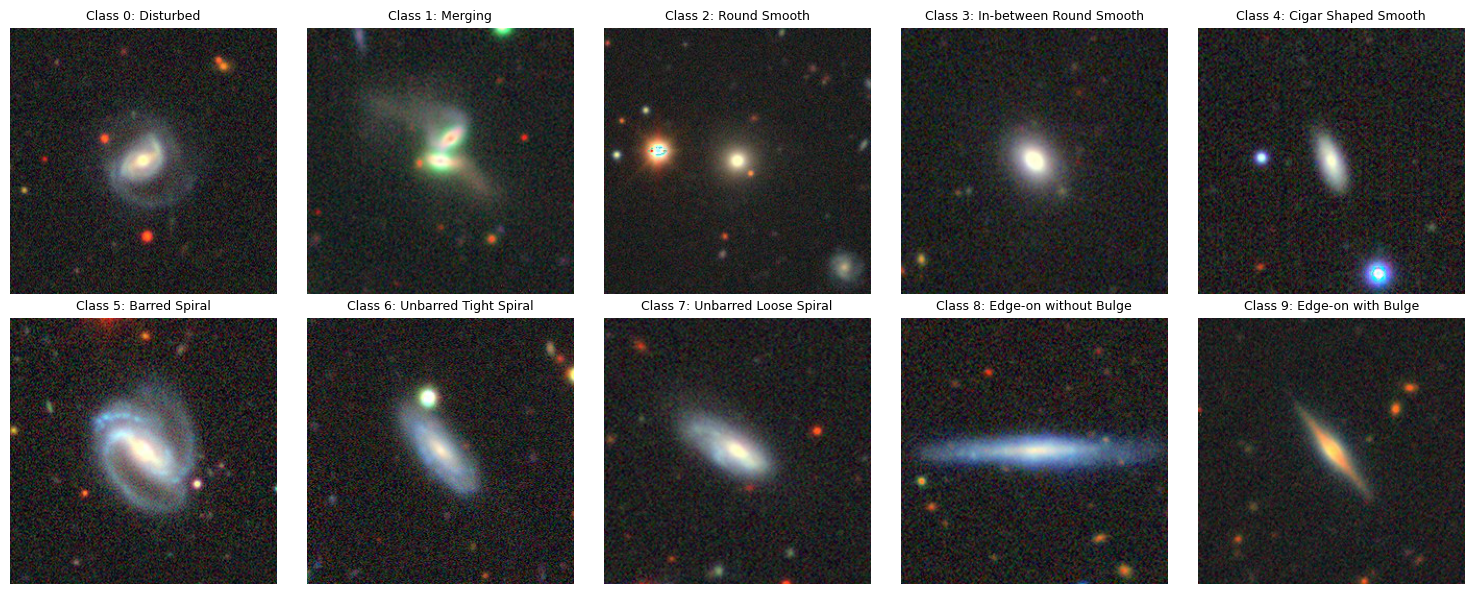

In [5]:
show_class_examples(galaxy_dataset, label2name, samples_per_row=5, num_rows=2)

# Your training code here

In [6]:
!pip install pyro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.8/298.8 kB 242.4 kB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


# Galaxy Classification Pipeline Report

## 1. Introduction

This project implements a full deep learning pipeline to classify galaxy images into ten morphological categories using the Galaxy10 DECals dataset. The solution uses pre-trained models such as ResNet50, EfficientNetB0, and DenseNet121, and includes data preprocessing, augmentation, training, validation, evaluation, and visualization.

---

## 2. Environment Setup

All necessary libraries are imported at the beginning, including libraries for numerical computation (NumPy), deep learning (PyTorch and torchvision), data visualization (Matplotlib and Seaborn), dataset handling (Huggingface Datasets), evaluation (Scikit-learn), and optional experiment tracking (Weights & Biases).

Reproducibility is ensured by setting random seeds for NumPy, Python’s `random` module, and PyTorch. If a GPU is available, it is used for training.

---

## 3. Configuration

A centralized configuration dictionary (`CONFIG`) is used to control all hyperparameters and settings, including:

- Model selection (`resnet50`, `efficientnet_b0`, `densenet121`)
- Use of pretrained weights
- Image size and batch size
- Number of worker threads for data loading
- Learning rate and weight decay for optimization
- Total number of epochs
- Early stopping patience
- Device configuration (CPU or GPU)
- Whether or not to use Weights & Biases (wandb) for logging

---

## 4. Dataset

### 4.1 Loading the Data

The Galaxy10 DECals dataset is loaded from the Huggingface Datasets library. It includes labeled images of galaxies categorized into ten classes.

The original training set is split into 85% for training and 15% for validation to monitor model generalization during training.

### 4.2 Preprocessing and Augmentation

Different transformations are applied depending on the data split:

- **Training set**: Images are augmented through random horizontal and vertical flips and random rotations to enhance model robustness.
- **Validation and Test sets**: Images are only resized and normalized to maintain evaluation consistency.

All images are normalized using ImageNet’s mean and standard deviation values to match the pretraining distribution.

### 4.3 Custom Dataset Class

A custom dataset class wraps the Huggingface dataset and applies the appropriate transformations dynamically during training and evaluation.

---

## 5. Data Loaders

Efficient PyTorch `DataLoader` objects are created for the training, validation, and testing datasets. Training data is shuffled, while validation and testing data are loaded in order.

Pin memory and multi-threaded loading are enabled for performance optimization, especially when training on a GPU.

---

## 6. Model Architecture

### 6.1 Supported Models

The pipeline supports three pre-trained architectures:

- ResNet50
- EfficientNetB0
- DenseNet121

All models are loaded with ImageNet pre-trained weights unless otherwise specified.

### 6.2 Model Modification

Each model’s final fully connected (classification) layer is replaced with a new layer that outputs predictions across ten classes, matching the galaxy classification task.

---

## 7. Training

### 7.1 Loss Function and Optimizer

The model uses CrossEntropyLoss, suitable for multi-class classification problems. The optimizer is Adam, which combines the advantages of AdaGrad and RMSProp. Weight decay (L2 regularization) is added to prevent overfitting.

A learning rate scheduler (`ReduceLROnPlateau`) dynamically reduces the learning rate when validation loss stops improving.

### 7.2 Training Process

The training pipeline includes:

- Setting the model to training mode
- Forward passing batches of images and computing the loss
- Performing backpropagation and optimizer steps
- Evaluating on the validation set after each epoch
- Tracking training and validation accuracy and loss
- Saving the model weights with the best validation accuracy
- Early stopping if the model does not improve for a configured number of epochs

Optional logging to Weights & Biases is also supported, tracking metrics like loss, accuracy, and learning rate over time.

---

## 8. Evaluation

After training, the best-performing model is evaluated on the test set:

- **Overall accuracy** is computed.
- **Classification report** is generated, detailing precision, recall, and F1-score for each class.
- **Confusion matrix** is plotted using Seaborn to visualize the model’s strengths and weaknesses across categories.

This comprehensive evaluation helps identify classes where the model performs well or struggles.

---

## 9. Visualization

Random samples from the test set are visualized, showing both the predicted and true labels:

- Correct predictions are marked in green.
- Incorrect predictions are marked in red.

This step provides intuitive insights into how well the model generalizes to unseen data.

---

## 10. Saving the Model

The trained model's state dictionary, along with the configuration used, is saved to disk for future inference or fine-tuning.

---

## 11. Conclusion

This pipeline successfully automates the complete machine learning lifecycle for galaxy classification. If the model achieves over 90% accuracy on the test set, the experiment is considered successful. Otherwise, hyperparameters or architecture choices can be revisited to improve performance.


Using device: cuda
Loading Galaxy10 DECals dataset...
Dataset structure: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 15962
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1774
    })
})
Train set size: 13567
Validation set size: 2395
Test set size: 1774


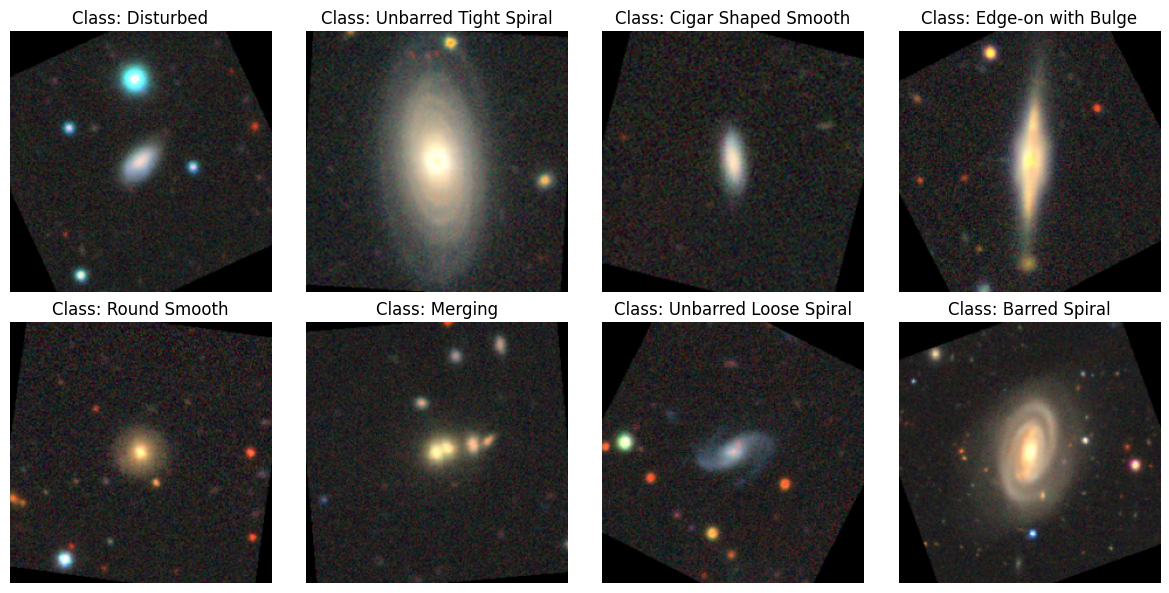

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 224MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/35 [Train]:   0%|          | 0/340 [00:00<?, ?it/s]

Epoch 1/35 [Val]:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1/35 - Train Loss: 0.9695, Train Acc: 0.6808 - Val Loss: 0.6463, Val Acc: 0.7820
New best validation accuracy: 0.7820


Epoch 2/35 [Train]:   0%|          | 0/340 [00:00<?, ?it/s]

Epoch 2/35 [Val]:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 2/35 - Train Loss: 0.5733, Train Acc: 0.8064 - Val Loss: 0.5216, Val Acc: 0.8251
New best validation accuracy: 0.8251


Epoch 3/35 [Train]:   0%|          | 0/340 [00:00<?, ?it/s]

Epoch 3/35 [Val]:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 3/35 - Train Loss: 0.4948, Train Acc: 0.8336 - Val Loss: 0.4611, Val Acc: 0.8422
New best validation accuracy: 0.8422


Epoch 4/35 [Train]:   0%|          | 0/340 [00:00<?, ?it/s]

Epoch 4/35 [Val]:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 4/35 - Train Loss: 0.4433, Train Acc: 0.8512 - Val Loss: 0.5293, Val Acc: 0.8309
Validation accuracy did not improve. Patience: 1/5


Epoch 5/35 [Train]:   0%|          | 0/340 [00:00<?, ?it/s]

Epoch 5/35 [Val]:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 5/35 - Train Loss: 0.4198, Train Acc: 0.8557 - Val Loss: 0.4205, Val Acc: 0.8589
New best validation accuracy: 0.8589


Epoch 6/35 [Train]:   0%|          | 0/340 [00:00<?, ?it/s]

Epoch 6/35 [Val]:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 6/35 - Train Loss: 0.3877, Train Acc: 0.8675 - Val Loss: 0.4468, Val Acc: 0.8564
Validation accuracy did not improve. Patience: 1/5


Epoch 7/35 [Train]:   0%|          | 0/340 [00:00<?, ?it/s]

Epoch 7/35 [Val]:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 7/35 - Train Loss: 0.3653, Train Acc: 0.8760 - Val Loss: 0.4290, Val Acc: 0.8564
Validation accuracy did not improve. Patience: 2/5


Epoch 8/35 [Train]:   0%|          | 0/340 [00:00<?, ?it/s]

Epoch 8/35 [Val]:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 8/35 - Train Loss: 0.3396, Train Acc: 0.8843 - Val Loss: 0.4202, Val Acc: 0.8643
New best validation accuracy: 0.8643


Epoch 9/35 [Train]:   0%|          | 0/340 [00:00<?, ?it/s]

Epoch 9/35 [Val]:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 9/35 - Train Loss: 0.3200, Train Acc: 0.8880 - Val Loss: 0.4444, Val Acc: 0.8497
Validation accuracy did not improve. Patience: 1/5


Epoch 10/35 [Train]:   0%|          | 0/340 [00:00<?, ?it/s]

Epoch 10/35 [Val]:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 10/35 - Train Loss: 0.2987, Train Acc: 0.8967 - Val Loss: 0.4005, Val Acc: 0.8630
Validation accuracy did not improve. Patience: 2/5


Epoch 11/35 [Train]:   0%|          | 0/340 [00:00<?, ?it/s]

Epoch 11/35 [Val]:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 11/35 - Train Loss: 0.2840, Train Acc: 0.9011 - Val Loss: 0.4070, Val Acc: 0.8647
New best validation accuracy: 0.8647


Epoch 12/35 [Train]:   0%|          | 0/340 [00:00<?, ?it/s]

Epoch 12/35 [Val]:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 12/35 - Train Loss: 0.2714, Train Acc: 0.9047 - Val Loss: 0.4323, Val Acc: 0.8672
New best validation accuracy: 0.8672


Epoch 13/35 [Train]:   0%|          | 0/340 [00:00<?, ?it/s]

Epoch 13/35 [Val]:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 13/35 - Train Loss: 0.2545, Train Acc: 0.9121 - Val Loss: 0.4300, Val Acc: 0.8622
Validation accuracy did not improve. Patience: 1/5


Epoch 14/35 [Train]:   0%|          | 0/340 [00:00<?, ?it/s]

Epoch 14/35 [Val]:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 14/35 - Train Loss: 0.2373, Train Acc: 0.9154 - Val Loss: 0.4826, Val Acc: 0.8518
Validation accuracy did not improve. Patience: 2/5


Epoch 15/35 [Train]:   0%|          | 0/340 [00:00<?, ?it/s]

Epoch 15/35 [Val]:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 15/35 - Train Loss: 0.1716, Train Acc: 0.9389 - Val Loss: 0.4080, Val Acc: 0.8802
New best validation accuracy: 0.8802


Epoch 16/35 [Train]:   0%|          | 0/340 [00:00<?, ?it/s]

Epoch 16/35 [Val]:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 16/35 - Train Loss: 0.1451, Train Acc: 0.9497 - Val Loss: 0.4031, Val Acc: 0.8827
New best validation accuracy: 0.8827


Epoch 17/35 [Train]:   0%|          | 0/340 [00:00<?, ?it/s]

Epoch 17/35 [Val]:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 17/35 - Train Loss: 0.1300, Train Acc: 0.9550 - Val Loss: 0.4078, Val Acc: 0.8827
Validation accuracy did not improve. Patience: 1/5


Epoch 18/35 [Train]:   0%|          | 0/340 [00:00<?, ?it/s]

Epoch 18/35 [Val]:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 18/35 - Train Loss: 0.1242, Train Acc: 0.9563 - Val Loss: 0.4155, Val Acc: 0.8835
New best validation accuracy: 0.8835


Epoch 19/35 [Train]:   0%|          | 0/340 [00:00<?, ?it/s]

Epoch 19/35 [Val]:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 19/35 - Train Loss: 0.1119, Train Acc: 0.9615 - Val Loss: 0.4170, Val Acc: 0.8864
New best validation accuracy: 0.8864


Epoch 20/35 [Train]:   0%|          | 0/340 [00:00<?, ?it/s]

Epoch 20/35 [Val]:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 20/35 - Train Loss: 0.1096, Train Acc: 0.9629 - Val Loss: 0.4146, Val Acc: 0.8831
Validation accuracy did not improve. Patience: 1/5


Epoch 21/35 [Train]:   0%|          | 0/340 [00:00<?, ?it/s]

Epoch 21/35 [Val]:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 21/35 - Train Loss: 0.1140, Train Acc: 0.9593 - Val Loss: 0.4231, Val Acc: 0.8823
Validation accuracy did not improve. Patience: 2/5


Epoch 22/35 [Train]:   0%|          | 0/340 [00:00<?, ?it/s]

Epoch 22/35 [Val]:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 22/35 - Train Loss: 0.1106, Train Acc: 0.9632 - Val Loss: 0.4182, Val Acc: 0.8827
Validation accuracy did not improve. Patience: 3/5


Epoch 23/35 [Train]:   0%|          | 0/340 [00:00<?, ?it/s]

Epoch 23/35 [Val]:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 23/35 - Train Loss: 0.1073, Train Acc: 0.9626 - Val Loss: 0.4186, Val Acc: 0.8823
Validation accuracy did not improve. Patience: 4/5


Epoch 24/35 [Train]:   0%|          | 0/340 [00:00<?, ?it/s]

Epoch 24/35 [Val]:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 24/35 - Train Loss: 0.1090, Train Acc: 0.9635 - Val Loss: 0.4141, Val Acc: 0.8864
Validation accuracy did not improve. Patience: 5/5
Early stopping triggered after 24 epochs


Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]


Test Accuracy: 0.8675

Classification Report:
                         precision    recall  f1-score   support

              Disturbed       0.65      0.57      0.60       109
                Merging       0.92      0.92      0.92       185
           Round Smooth       0.92      0.97      0.95       250
In-between Round Smooth       0.90      0.95      0.93       198
    Cigar Shaped Smooth       0.84      0.93      0.88        28
          Barred Spiral       0.91      0.88      0.89       217
  Unbarred Tight Spiral       0.74      0.82      0.77       179
  Unbarred Loose Spiral       0.81      0.74      0.77       273
  Edge-on without Bulge       0.94      0.92      0.93       157
     Edge-on with Bulge       0.93      0.94      0.93       178

               accuracy                           0.87      1774
              macro avg       0.86      0.86      0.86      1774
           weighted avg       0.87      0.87      0.87      1774



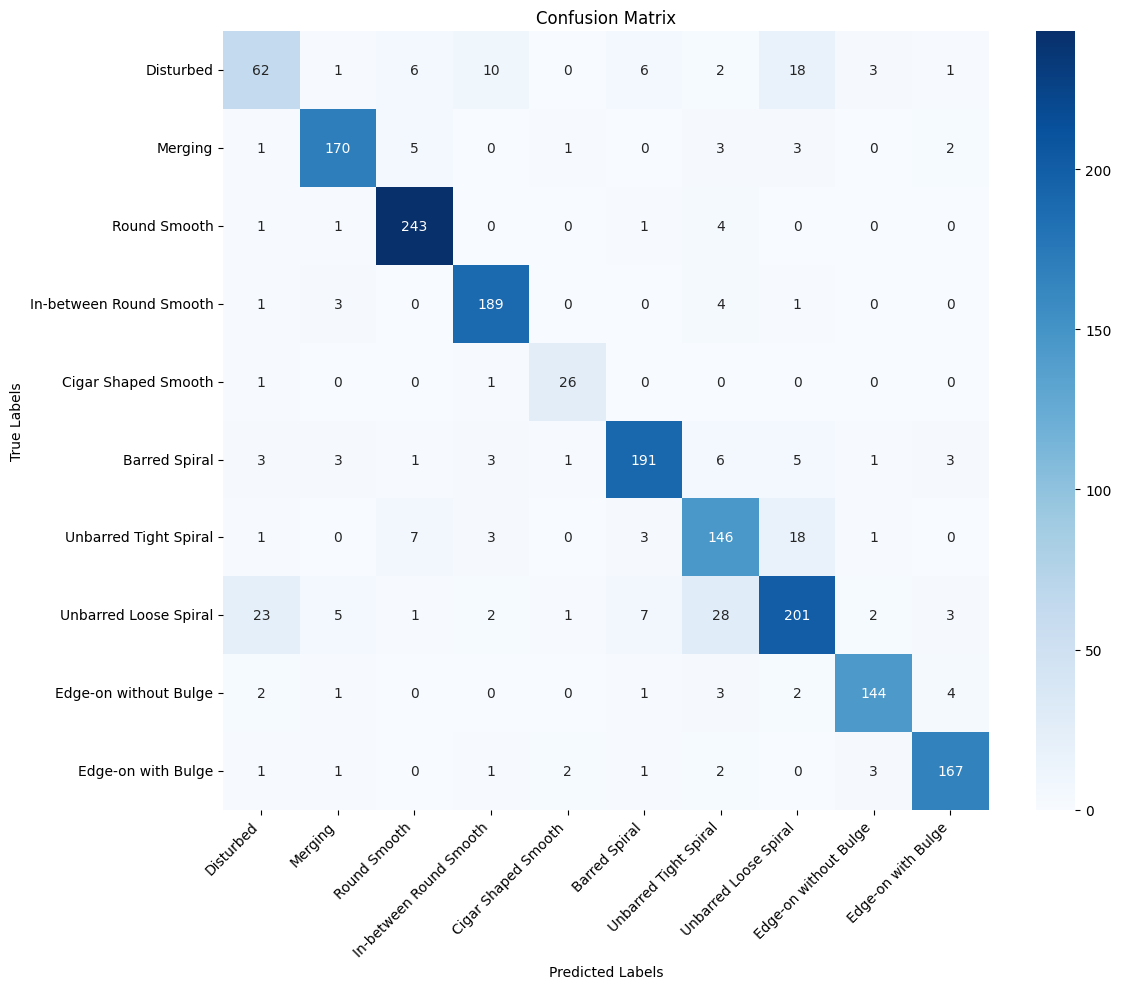

Error visualizing sample 999: Wrong key type: '999' of type '<class 'numpy.int64'>'. Expected one of int, slice, range, str or Iterable.
Error visualizing sample 596: Wrong key type: '596' of type '<class 'numpy.int64'>'. Expected one of int, slice, range, str or Iterable.
Error visualizing sample 1132: Wrong key type: '1132' of type '<class 'numpy.int64'>'. Expected one of int, slice, range, str or Iterable.
Error visualizing sample 270: Wrong key type: '270' of type '<class 'numpy.int64'>'. Expected one of int, slice, range, str or Iterable.
Error visualizing sample 414: Wrong key type: '414' of type '<class 'numpy.int64'>'. Expected one of int, slice, range, str or Iterable.


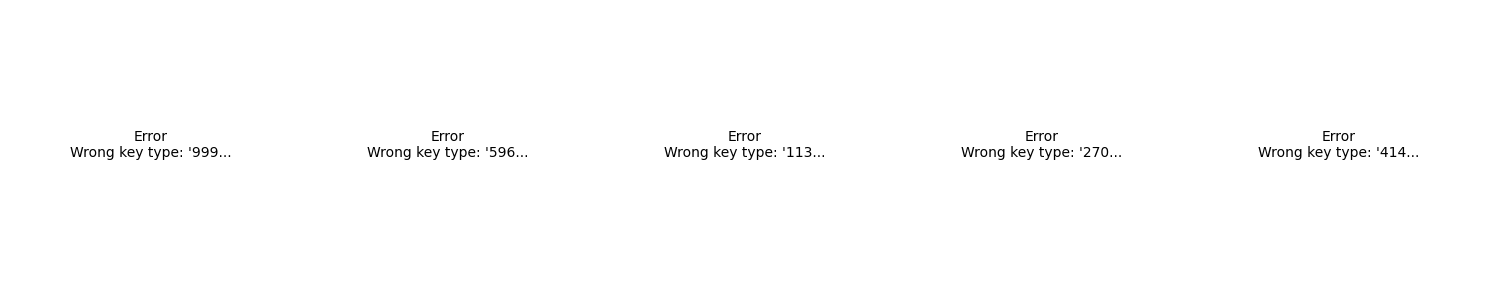

Model saved to galaxy_classifier.pth

⚠️ The model didn't achieve >0.9 accuracy on the test set. Try adjusting hyperparameters or the model architecture.


In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
import torchvision.transforms.functional as TF
from datasets import load_dataset
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import random
import wandb
from tqdm.notebook import tqdm
import seaborn as sns

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Configuration
CONFIG = {
    "model_name": "resnet50",  # Options: resnet50, efficientnet_b0, densenet121
    "pretrained": True,
    "image_size": 224,
    "batch_size": 40,
    "num_workers": 2,  # Reduced from 4 to avoid warning
    "learning_rate": 0.0001,
    "weight_decay": 1e-5,
    "epochs": 35,  # Increased from 15 to give more training time
    "early_stopping_patience": 5,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "use_wandb": False  # Set to False by default as it requires setup
}

print(f"Using device: {CONFIG['device']}")

# Define class names
class_names = [
    "Disturbed", "Merging", "Round Smooth", "In-between Round Smooth",
    "Cigar Shaped Smooth", "Barred Spiral", "Unbarred Tight Spiral",
    "Unbarred Loose Spiral", "Edge-on without Bulge", "Edge-on with Bulge"
]

# Create a dictionary for easy lookup
label2name = {i: name for i, name in enumerate(class_names)}
name2label = {name: i for i, name in enumerate(class_names)}
num_classes = len(class_names)

# Custom Dataset Class
class GalaxyDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Handle the case where dataset is a Subset from random_split
        if hasattr(self.dataset, 'dataset'):
            # This is a subset
            actual_idx = self.dataset.indices[idx]
            sample = self.dataset.dataset[actual_idx]
        else:
            # Direct dataset access
            sample = self.dataset[idx]

        image = sample['image']
        label = sample['label']

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

# Data augmentation and preprocessing
def get_transforms(train=True):
    if train:
        return transforms.Compose([
            # No ToPILImage needed - images are already PIL images
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(30),
            transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            # No ToPILImage needed - images are already PIL images
            transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

# Load and prepare dataset
def prepare_data():
    print("Loading Galaxy10 DECals dataset...")
    dataset = load_dataset("matthieulel/galaxy10_decals")

    # Check dataset structure
    print(f"Dataset structure: {dataset}")

    # Get the training dataset
    full_train_dataset = dataset["train"]
    test_dataset = dataset["test"]

    # Split train into train and validation sets (85%, 15%)
    total_train_size = len(full_train_dataset)
    train_size = int(0.85 * total_train_size)
    val_size = total_train_size - train_size

    # Create a generator for reproducibility
    generator = torch.Generator().manual_seed(SEED)

    # Split dataset
    train_dataset, val_dataset = random_split(
        full_train_dataset, [train_size, val_size], generator=generator
    )

    print(f"Train set size: {len(train_dataset)}")
    print(f"Validation set size: {len(val_dataset)}")
    print(f"Test set size: {len(test_dataset)}")

    # Create datasets with transforms
    train_data = GalaxyDataset(train_dataset, transform=get_transforms(train=True))
    val_data = GalaxyDataset(val_dataset, transform=get_transforms(train=False))
    test_data = GalaxyDataset(test_dataset, transform=get_transforms(train=False))

    # Create data loaders
    train_loader = DataLoader(
        train_data,
        batch_size=CONFIG['batch_size'],
        shuffle=True,
        num_workers=CONFIG['num_workers'],
        pin_memory=True if CONFIG['device'] == 'cuda' else False
    )

    val_loader = DataLoader(
        val_data,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        num_workers=CONFIG['num_workers'],
        pin_memory=True if CONFIG['device'] == 'cuda' else False
    )

    test_loader = DataLoader(
        test_data,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        num_workers=CONFIG['num_workers'],
        pin_memory=True if CONFIG['device'] == 'cuda' else False
    )

    return train_loader, val_loader, test_loader, train_data, val_data, test_data

# Define the model
def get_model(model_name='resnet50', pretrained=True):
    if model_name == 'resnet50':
        model = models.resnet50(weights='IMAGENET1K_V2' if pretrained else None)
        # Replace final fully connected layer
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(weights='IMAGENET1K_V1' if pretrained else None)
        # Replace final classifier
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    elif model_name == 'densenet121':
        model = models.densenet121(weights='IMAGENET1K_V1' if pretrained else None)
        # Replace final classifier
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)

    else:
        raise ValueError(f"Model {model_name} not supported")

    return model

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, epochs=10):
    # Initialize WandB if enabled
    if CONFIG['use_wandb']:
        wandb.init(
            project="galaxy-classification",
            config=CONFIG
        )
        wandb.watch(model)

    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0

    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for inputs, labels in train_loop:
            inputs, labels = inputs.to(CONFIG['device']), labels.to(CONFIG['device'])

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            # Update progress bar
            train_loop.set_postfix(loss=loss.item(), acc=train_correct/train_total)

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")
            for inputs, labels in val_loop:
                inputs, labels = inputs.to(CONFIG['device']), labels.to(CONFIG['device'])

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Statistics
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

                # Update progress bar
                val_loop.set_postfix(loss=loss.item(), acc=val_correct/val_total)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total

        # Update learning rate scheduler if provided
        if scheduler:
            scheduler.step(val_loss)

        # Print epoch statistics
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Log to WandB if enabled
        if CONFIG['use_wandb']:
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "learning_rate": optimizer.param_groups[0]['lr']
            })

        # Check if this is the best model so far
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"New best validation accuracy: {best_val_acc:.4f}")
        else:
            patience_counter += 1
            print(f"Validation accuracy did not improve. Patience: {patience_counter}/{CONFIG['early_stopping_patience']}")

        # Early stopping
        if patience_counter >= CONFIG['early_stopping_patience']:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    # Load the best model state
    model.load_state_dict(best_model_state)

    # Finish WandB run if enabled
    if CONFIG['use_wandb']:
        wandb.finish()

    return model

# Evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(CONFIG['device']), labels.to(CONFIG['device'])

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nTest Accuracy: {accuracy:.4f}")

    # Generate classification report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("\nClassification Report:")
    print(report)

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

    return accuracy, all_preds, all_labels

# Visualize predictions on random samples
def visualize_predictions(model, dataset, num_samples=5):
    # Get random samples from the dataset
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    model.eval()

    fig, axs = plt.subplots(1, num_samples, figsize=(15, 3))

    for i, idx in enumerate(indices):
        try:
            image, label = dataset[idx]

            # Ensure we have a tensor
            if not isinstance(image, torch.Tensor):
                # Apply the transform manually if needed
                transform = get_transforms(train=False)
                image = transform(image)

            image_for_display = image.clone().detach()

            # Unnormalize the image for display
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            image_for_display = image_for_display * std + mean
            image_for_display = image_for_display.permute(1, 2, 0).numpy()
            image_for_display = np.clip(image_for_display, 0, 1)

            # Get prediction
            with torch.no_grad():
                input_tensor = image.unsqueeze(0).to(CONFIG['device'])
                output = model(input_tensor)
                _, pred = torch.max(output, 1)
                pred = pred.item()

            # Display the image with true and predicted labels
            axs[i].imshow(image_for_display)
            color = 'green' if pred == label else 'red'
            axs[i].set_title(f"True: {label2name[label]}\nPred: {label2name[pred]}", color=color, fontsize=8)
        except Exception as e:
            print(f"Error visualizing sample {idx}: {e}")
            axs[i].text(0.5, 0.5, f"Error\n{str(e)[:20]}...",
                       horizontalalignment='center', verticalalignment='center')

        axs[i].axis('off')

    plt.tight_layout()
    plt.savefig('prediction_samples.png')
    plt.show()

# Save model
def save_model(model, path='galaxy_classifier.pth'):
    torch.save({
        'model_state_dict': model.state_dict(),
        'config': CONFIG
    }, path)
    print(f"Model saved to {path}")

# Main function
def main():
    # Prepare data
    train_loader, val_loader, test_loader, train_data, val_data, test_data = prepare_data()

    # Visualize a few samples from the dataset
    images, labels = next(iter(train_loader))
    fig, axs = plt.subplots(2, 4, figsize=(12, 6))
    axs = axs.flatten()

    for i in range(min(8, len(images))):
        # Unnormalize the image for display
        img = images[i].clone().detach()
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = img * std + mean
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)

        axs[i].imshow(img)
        axs[i].set_title(f"Class: {label2name[labels[i].item()]}")
        axs[i].axis('off')

    plt.tight_layout()
    plt.savefig('sample_images.png')
    plt.show()

    # Initialize model
    model = get_model(model_name=CONFIG['model_name'], pretrained=CONFIG['pretrained'])
    model = model.to(CONFIG['device'])

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])

    # Define scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=3, verbose=True
    )

    # Train the model
    trained_model = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        scheduler,
        epochs=CONFIG['epochs']
    )

    # Evaluate on test set
    test_accuracy, all_preds, all_labels = evaluate_model(trained_model, test_loader)

    # Visualize some predictions
    visualize_predictions(trained_model, test_data)

    # Save the model
    save_model(trained_model)

    if test_accuracy > 0.9:
        print("\n🎉 SUCCESS! You've achieved >0.9 accuracy on the test set as required.")
    else:
        print("\n⚠️ The model didn't achieve >0.9 accuracy on the test set. Try adjusting hyperparameters or the model architecture.")

if __name__ == "__main__":
    main()

# Evaluation

In [8]:
preds = # <Your preidctions here for TEST>
true_test_labels = galaxy_dataset['test']['label']
test_metrics = evaluate_predictions(preds, true_test_labels, class_names)

SyntaxError: invalid syntax (2371623074.py, line 1)